<a href="https://colab.research.google.com/github/cooperlee0412/ECE570FinalProject/blob/main/Project570_test4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing and Installation**

In [ ]:
!pip install torch numpy matplotlib PyMCubes
import mcubes
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.8/336.8 kB 29.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

# **Step 1: Dataset Introduction**

In [ ]:
def generate_voxel_cube(size=16, cube_size=12):
    v = np.zeros((size, size, size), dtype=np.float32)
    s, e = (size - cube_size) // 2, (size + cube_size) // 2
    v[s:e, s:e, s:e] = 1.0
    return v

dataset = torch.tensor([generate_voxel_cube() for _ in range(1000)]).unsqueeze(1)

<ipython-input-2-693cdf103a0a>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  dataset = torch.tensor([generate_voxel_cube() for _ in range(1000)]).unsqueeze(1)


# **Step 2: Sinusoidal Time Embedding**


In [ ]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half = self.dim // 2
        emb = torch.exp(torch.arange(half, device=device) * -(np.log(10000) / half))
        emb = t[:, None] * emb[None, :]
        return torch.cat([emb.sin(), emb.cos()], dim=-1)

# **Step 3: Model Introduction**

In [ ]:
class CubeDenoiser(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embed = nn.Sequential(
            SinusoidalTimeEmbedding(64),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )
        self.conv1 = nn.Conv3d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv3d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv3d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv3d(32, 1, 3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        x = self.relu(self.conv1(x))
        t_embed = self.time_embed(t).view(-1, 32, 1, 1, 1)
        x = x + t_embed
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        return torch.sigmoid(self.conv4(x))  # squash to [0,1]

# **Step 4: Cosine Noise Schedule**

In [ ]:
def cosine_schedule(T):
    steps = torch.arange(T + 1, dtype=torch.float64) / T
    alphas_bar = torch.cos((steps + 0.008) / 1.008 * np.pi / 2) ** 2
    alphas_bar = alphas_bar / alphas_bar[0]
    betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
    return betas.float()

def get_schedule(T=100):
    betas = cosine_schedule(T)
    alphas = 1. - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    return betas, alphas, alpha_bars

# **Step 5: Training**

In [ ]:
def train_ddpm(model, dataset, T=100, epochs=50, batch_size=8):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    betas, alphas, alpha_bars = get_schedule(T)
    alpha_bars = alpha_bars.to(device)

    for epoch in range(epochs):
        for x0 in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
            x0 = x0.to(device)
            B = x0.shape[0]
            t = torch.randint(0, T, (B,), device=device).long()
            a = alpha_bars[t].view(-1, 1, 1, 1, 1)
            noise = torch.randn_like(x0)
            xt = torch.sqrt(a) * x0 + torch.sqrt(1 - a) * noise

            pred = model(xt, t.float())
            loss = nn.MSELoss()(pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

# **Step 6: Sampling with Stability Protection**

In [ ]:
@torch.no_grad()
def sample_ddpm(model, size=16, T=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    betas, alphas, alpha_bars = get_schedule(T)
    x = torch.randn(1, 1, size, size, size).to(device)

    for t in reversed(range(T)):
        t_tensor = torch.full((1,), t, device=device)
        alpha = alphas[t].to(device)
        alpha_bar = alpha_bars[t].to(device)
        beta = betas[t].to(device)
        pred_noise = model(x, t_tensor.float())
        noise = torch.randn_like(x) if t > 0 else 0

        x = (1 / torch.sqrt(alpha)) * (
            x - (1 - alpha) / torch.sqrt(1 - alpha_bar) * pred_noise
        ) + torch.sqrt(beta) * noise

        x = torch.nan_to_num(x, nan=0.0)
        x = torch.clamp(x, 0.0, 1.0)

    return x.cpu().squeeze().numpy()

# **Step 7: Visualization**

In [ ]:
def plot_cube(cube, threshold=0.5):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(cube > threshold, edgecolor='k')
    plt.title(f"Thresholded Cube (th={threshold})")
    plt.show()

def show_middle_slice(cube):
    plt.imshow(cube[cube.shape[0] // 2], cmap='gray')
    plt.title("Middle Slice")
    plt.axis('off')
    plt.show()

def plot_histogram(cube):
    plt.hist(cube.flatten(), bins=100)
    plt.title("Voxel Value Distribution")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

# **Step 8: Cube Generating**

Epoch 1/50: 100%|██████████| 125/125 [00:02<00:00, 56.60it/s] 


Epoch 1 Loss: 0.9985


Epoch 2/50: 100%|██████████| 125/125 [00:00<00:00, 133.48it/s]


Epoch 2 Loss: 1.0013


Epoch 3/50: 100%|██████████| 125/125 [00:00<00:00, 134.20it/s]


Epoch 3 Loss: 0.9973


Epoch 4/50: 100%|██████████| 125/125 [00:00<00:00, 133.13it/s]


Epoch 4 Loss: 1.0012


Epoch 5/50: 100%|██████████| 125/125 [00:00<00:00, 133.18it/s]


Epoch 5 Loss: 1.0243


Epoch 6/50: 100%|██████████| 125/125 [00:00<00:00, 132.87it/s]


Epoch 6 Loss: 0.9910


Epoch 7/50: 100%|██████████| 125/125 [00:00<00:00, 130.68it/s]


Epoch 7 Loss: 0.9909


Epoch 8/50: 100%|██████████| 125/125 [00:00<00:00, 128.72it/s]


Epoch 8 Loss: 0.9978


Epoch 9/50: 100%|██████████| 125/125 [00:00<00:00, 127.89it/s]


Epoch 9 Loss: 0.9781


Epoch 10/50: 100%|██████████| 125/125 [00:00<00:00, 131.82it/s]


Epoch 10 Loss: 1.0049


Epoch 11/50: 100%|██████████| 125/125 [00:00<00:00, 132.30it/s]


Epoch 11 Loss: 0.9878


Epoch 12/50: 100%|██████████| 125/125 [00:00<00:00, 132.51it/s]


Epoch 12 Loss: 0.9986


Epoch 13/50: 100%|██████████| 125/125 [00:00<00:00, 129.65it/s]


Epoch 13 Loss: 1.0043


Epoch 14/50: 100%|██████████| 125/125 [00:00<00:00, 129.26it/s]


Epoch 14 Loss: 0.9944


Epoch 15/50: 100%|██████████| 125/125 [00:00<00:00, 131.95it/s]


Epoch 15 Loss: 0.9877


Epoch 16/50: 100%|██████████| 125/125 [00:00<00:00, 131.34it/s]


Epoch 16 Loss: 1.0068


Epoch 17/50: 100%|██████████| 125/125 [00:00<00:00, 131.38it/s]


Epoch 17 Loss: 1.0073


Epoch 18/50: 100%|██████████| 125/125 [00:00<00:00, 130.98it/s]


Epoch 18 Loss: 1.0071


Epoch 19/50: 100%|██████████| 125/125 [00:00<00:00, 131.59it/s]


Epoch 19 Loss: 0.9966


Epoch 20/50: 100%|██████████| 125/125 [00:00<00:00, 126.11it/s]


Epoch 20 Loss: 1.0047


Epoch 21/50: 100%|██████████| 125/125 [00:00<00:00, 125.93it/s]


Epoch 21 Loss: 0.9842


Epoch 22/50: 100%|██████████| 125/125 [00:00<00:00, 128.36it/s]


Epoch 22 Loss: 1.0029


Epoch 23/50: 100%|██████████| 125/125 [00:00<00:00, 129.84it/s]


Epoch 23 Loss: 0.9973


Epoch 24/50: 100%|██████████| 125/125 [00:00<00:00, 129.61it/s]


Epoch 24 Loss: 1.0019


Epoch 25/50: 100%|██████████| 125/125 [00:00<00:00, 129.13it/s]


Epoch 25 Loss: 1.0028


Epoch 26/50: 100%|██████████| 125/125 [00:00<00:00, 129.50it/s]


Epoch 26 Loss: 1.0058


Epoch 27/50: 100%|██████████| 125/125 [00:00<00:00, 129.00it/s]


Epoch 27 Loss: 0.9894


Epoch 28/50: 100%|██████████| 125/125 [00:00<00:00, 129.19it/s]


Epoch 28 Loss: 1.0067


Epoch 29/50: 100%|██████████| 125/125 [00:00<00:00, 128.80it/s]


Epoch 29 Loss: 0.9926


Epoch 30/50: 100%|██████████| 125/125 [00:00<00:00, 129.05it/s]


Epoch 30 Loss: 0.9975


Epoch 31/50: 100%|██████████| 125/125 [00:00<00:00, 129.68it/s]


Epoch 31 Loss: 0.9943


Epoch 32/50: 100%|██████████| 125/125 [00:00<00:00, 127.53it/s]


Epoch 32 Loss: 1.0042


Epoch 33/50: 100%|██████████| 125/125 [00:00<00:00, 125.72it/s]


Epoch 33 Loss: 1.0081


Epoch 34/50: 100%|██████████| 125/125 [00:00<00:00, 125.10it/s]


Epoch 34 Loss: 1.0106


Epoch 35/50: 100%|██████████| 125/125 [00:00<00:00, 128.06it/s]


Epoch 35 Loss: 1.0029


Epoch 36/50: 100%|██████████| 125/125 [00:00<00:00, 127.71it/s]


Epoch 36 Loss: 1.0054


Epoch 37/50: 100%|██████████| 125/125 [00:00<00:00, 127.42it/s]


Epoch 37 Loss: 0.9935


Epoch 38/50: 100%|██████████| 125/125 [00:00<00:00, 126.95it/s]


Epoch 38 Loss: 0.9991


Epoch 39/50: 100%|██████████| 125/125 [00:00<00:00, 127.84it/s]


Epoch 39 Loss: 1.0000


Epoch 40/50: 100%|██████████| 125/125 [00:00<00:00, 126.99it/s]


Epoch 40 Loss: 0.9977


Epoch 41/50: 100%|██████████| 125/125 [00:00<00:00, 127.51it/s]


Epoch 41 Loss: 0.9996


Epoch 42/50: 100%|██████████| 125/125 [00:00<00:00, 126.60it/s]


Epoch 42 Loss: 0.9900


Epoch 43/50: 100%|██████████| 125/125 [00:00<00:00, 126.88it/s]


Epoch 43 Loss: 1.0002


Epoch 44/50: 100%|██████████| 125/125 [00:00<00:00, 125.93it/s]


Epoch 44 Loss: 1.0031


Epoch 45/50: 100%|██████████| 125/125 [00:01<00:00, 120.94it/s]


Epoch 45 Loss: 0.9836


Epoch 46/50: 100%|██████████| 125/125 [00:01<00:00, 122.88it/s]


Epoch 46 Loss: 0.9940


Epoch 47/50: 100%|██████████| 125/125 [00:00<00:00, 126.25it/s]


Epoch 47 Loss: 1.0148


Epoch 48/50: 100%|██████████| 125/125 [00:00<00:00, 125.86it/s]


Epoch 48 Loss: 0.9956


Epoch 49/50: 100%|██████████| 125/125 [00:00<00:00, 125.88it/s]


Epoch 49 Loss: 0.9932


Epoch 50/50: 100%|██████████| 125/125 [00:00<00:00, 125.84it/s]


Epoch 50 Loss: 0.9938
No NaNs in generated cube.
✅ Exported mesh to 'generated_cube.obj'


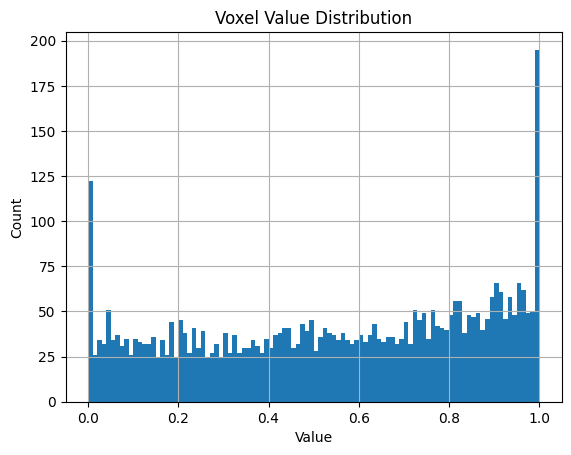

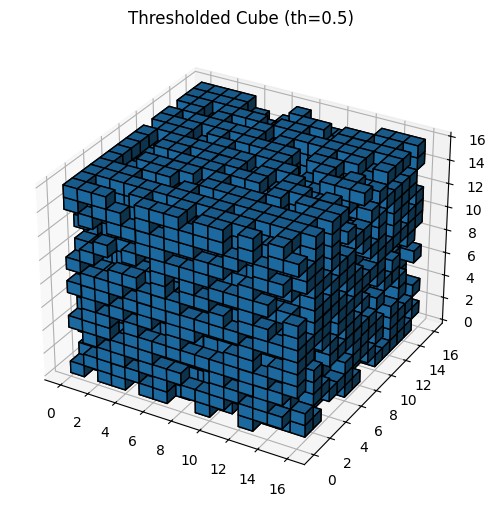

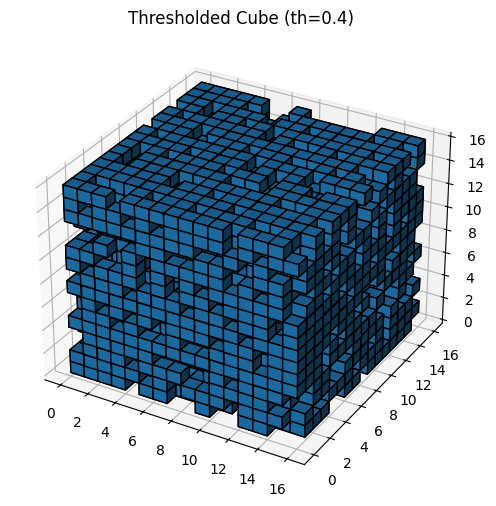

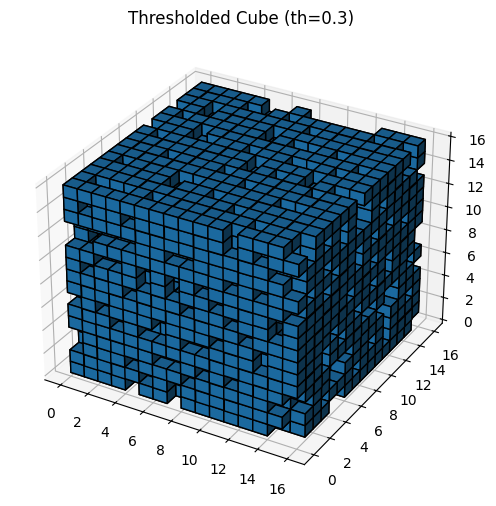

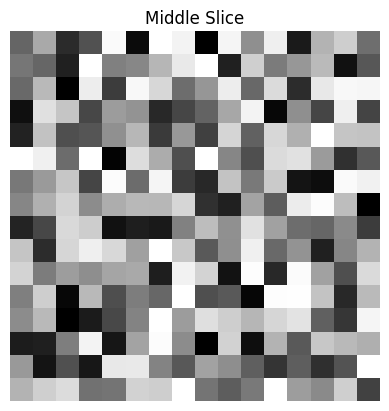

In [ ]:
model = CubeDenoiser()
train_ddpm(model, dataset, epochs=50, T=100)

gen = sample_ddpm(model, size=16, T=100)

# Dafety fallback
if np.isnan(gen).any():
    print("NaNs detected! Replacing with zeros.")
    gen = np.nan_to_num(gen, nan=0.0)
else:
    print("No NaNs in generated cube.")

# Save voxel grid as .npy
np.save("generated_cube.npy", gen)
# Save as .obj by
import mcubes
threshold = 0.4
vertices, triangles = mcubes.marching_cubes(gen, threshold)
mcubes.export_obj(vertices, triangles, "generated_cube.obj")
print("Exported mesh to 'generated_cube.obj'")

# Visualize
plot_histogram(gen)
for th in [0.5, 0.4, 0.3]:
    plot_cube(gen, threshold=th)

show_middle_slice(gen)